In [99]:
%run Dataloader.ipynb

otto-group-product-classification-challenge.zip: Skipping, found more recently modified local copy (use --force to force download)


In [100]:
import torch
from torch.utils import data
from torch.autograd import Variable
import torch.nn as  nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt

In [101]:
#Normalise data
std_dev = train_x.std(axis=0)
mean = train_x.mean(axis=0)
transform_norm = lambda x: (x - mean) / std_dev

#Dataset loader
class Dataset_VAE(data.Dataset):
  'Characterizes a dataset for PyTorch'
  def __init__(self, dataframe_x, dataframe_y):
        'Initialization'
        self.labels = torch.tensor(dataframe_y.values)
        self.features = torch.tensor(transform_norm(dataframe_x).values)
        

  def __len__(self):
        'Denotes the total number of samples'
        return len(self.labels)

  def __getitem__(self, index):
        'Generates one sample of data'
        X = self.features[index,:]
        y = self.labels[index]

        return X, y
    
batch_size = 64

# Generators
training_set = Dataset_VAE(train_x, train_y)
train_loader = torch.utils.data.DataLoader(
    training_set
    ,batch_size=batch_size
    ,shuffle=True
                )

In [109]:
class VAE(nn.Module):
    #Define the layers in the init statement
    def __init__(self):
        super(VAE, self).__init__()
        
        #Encoder
        self.encoder = nn.Sequential(
            nn.Linear(93, 40),
            nn.ReLU(True),
            nn.Linear(40, 10),
            nn.ReLU(True),
            nn.Linear(10, 2),
        )
        #Decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 10),
            nn.ReLU(True),
            nn.Linear(10, 40),
            nn.ReLU(True),
            nn.Linear(40, 93),
        )

        self.losses = []
        self.accuracy = []
        self.valid_losses = []
        self.valid_accuracy = []
        
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
    def train_net(self, train_set, lr):
        #Define loss and optimiser
        loss_func = nn.MSELoss()
        optimiser = optim.Adam(net.parameters(), lr = lr)
        
        epoch = 0
        print('Commencing training')
        while epoch < 50:           #Value of 0.2 set by trial and error
            epoch +=1   
            current_loss = 0.0

            #Loop over mini-batches
            for batch_index, training_batch in enumerate(train_set, 0):

                #Transform inputs and labels into the right size and type for the loss func.
                inputs, labels = training_batch
                inputs = inputs.float()
                labels = labels.float()
                labels = labels.unsqueeze_(1)
                inputs, labels = Variable(inputs), Variable(labels)

                #Zero opt and calculate feedforward
                optimiser.zero_grad()
                outputs = self.forward(inputs)

                #Calculate loss and propagate backwards
                loss = loss_func(outputs, labels)
                loss.backward()  #Propagate losses backwards
                optimiser.step() #Update weights

                current_loss += loss.item()  #Add batch loss to calculate epoch loss

                #Compute average batch loss and accuracy every 1000 batches
                if batch_index == 772:
                    print('     [Epoch: %d] loss: %.3f' %
                         (epoch, current_loss / 1000))
                    self.losses.append(current_loss/1000)

In [110]:
net = VAE()
net.train_net(train_loader, lr = 0.0005)

Commencing training
     [Epoch: 1] loss: 4.080
     [Epoch: 2] loss: 1.513
     [Epoch: 3] loss: 1.369
     [Epoch: 4] loss: 1.284
     [Epoch: 5] loss: 1.228
     [Epoch: 6] loss: 1.187
     [Epoch: 7] loss: 1.147
     [Epoch: 8] loss: 1.114
     [Epoch: 9] loss: 1.089
     [Epoch: 10] loss: 1.063
     [Epoch: 11] loss: 1.043
     [Epoch: 12] loss: 1.025
     [Epoch: 13] loss: 1.010
     [Epoch: 14] loss: 0.994
     [Epoch: 15] loss: 0.979
     [Epoch: 16] loss: 0.964
     [Epoch: 17] loss: 0.954
     [Epoch: 18] loss: 0.936
     [Epoch: 19] loss: 0.925
     [Epoch: 20] loss: 0.917
     [Epoch: 21] loss: 0.904
     [Epoch: 22] loss: 0.894
     [Epoch: 23] loss: 0.886
     [Epoch: 24] loss: 0.878
     [Epoch: 25] loss: 0.870
     [Epoch: 26] loss: 0.860
     [Epoch: 27] loss: 0.854
     [Epoch: 28] loss: 0.846
     [Epoch: 29] loss: 0.841
     [Epoch: 30] loss: 0.828
     [Epoch: 31] loss: 0.819
     [Epoch: 32] loss: 0.813
     [Epoch: 33] loss: 0.809
     [Epoch: 34] loss: 0.800
   

In [150]:
transformed_x = (torch.tensor(transform_norm(train_x).values)).float()

points = net.encoder(transformed_x).detach().numpy()

df = pd.DataFrame(points)
df['targets'] = train_y.values.astype(np.int64)

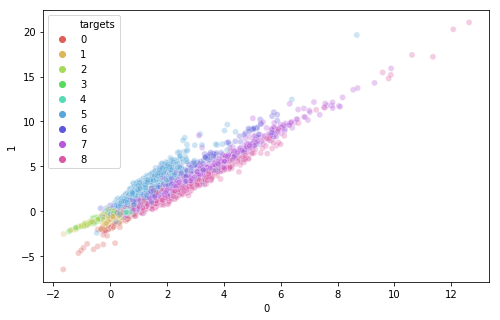

In [156]:
import seaborn as sns
plt.figure(figsize=(8,5))
sns.scatterplot(
    x=0, y=1,
    hue="targets",
    data=df,
    legend="full",
    palette=sns.color_palette("hls", 9),
    alpha=0.3)

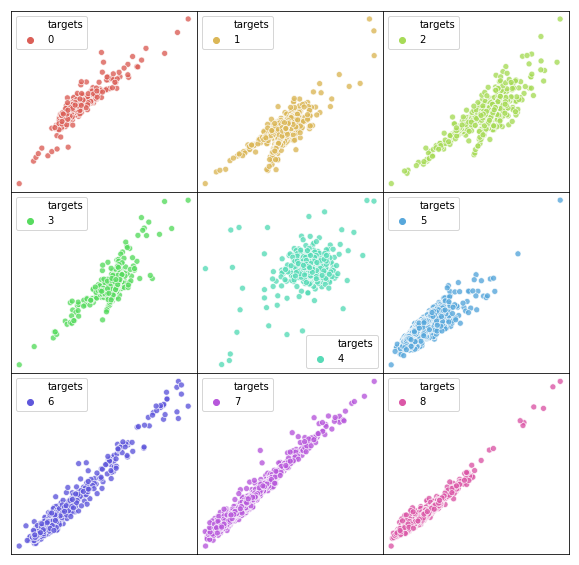

In [157]:
fig, axes = plt.subplots(3,3, figsize = (10,10))
fig.subplots_adjust(hspace=0,wspace=0)

for i, ax in enumerate(axes.flat):
    
    ax.xaxis.set_major_locator(plt.NullLocator())
    ax.yaxis.set_major_locator(plt.NullLocator())
    
    data = df[df['targets'] == i]
    sns.scatterplot(x=0, y=1,
                         data=data,
                         hue = 'targets',
                         legend="full",alpha=0.8, color = 'k',
                          palette = [sns.color_palette("hls", 9)[i]],
                           ax = ax)

In [153]:
df.to_pickle("./VAE_train.pkl")

In [155]:
transformed_val_x = (torch.tensor(transform_norm(val_x).values)).float()

points = net.encoder(transformed_val_x).detach().numpy()

df = pd.DataFrame(points)
df['targets'] = val_y.values.astype(np.int64)

df.to_pickle("./VAE_val.pkl")